#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
3. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
4. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)

In [1]:
import random
import torch
import numpy as np

def fix_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [2]:
fix_seed(555)

### Import required modules

In [3]:
from model.vrae import VRAE

from model.utils import *
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange
import tqdm

import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler


### Input parameters

In [4]:
dload = './saved_model' #download directory

### utils.load_data

In [5]:
def load_gen_data(file_name, scale_type = 'Standard', cols_to_remove = None):
    """
    folder: folder where data is located
    """
    
    # define path(must be in pkl file)
    data_loc = f'./data/netis/{file_name}.pkl'    
    
    # get data
    with open(data_loc, 'rb') as f:
        df = pickle.load(f)
    
    # if needed remove columns that is not necessary
    if cols_to_remove != None:
        df = df_total.drop(cols_to_remove, axis=1)
    
    df = df.dropna()
    
    # TRAIN TEST SPLIT
    # TRAIN
    TRAIN_DF = df.query('Time < 20211103184400 or Time > 20211106084400 and label==0')
    
    # TEST(GET ONLY 정상)
    TEST_DF = df.query('Time >= 20211103184400 and Time <= 20211106084400 and label==0')

    TOTAL_DF = df.to_numpy()
    
    # REMOVE TIME & LABEL
    TRAIN_DF = TRAIN_DF.iloc[:,1:-1]
    cols = TRAIN_DF.columns
    TRAIN_DF = TRAIN_DF.to_numpy()
    TEST_DF = TEST_DF.iloc[:,1:-1].to_numpy()
    
    if scale_type == 'MinMax':
        scaler = MinMaxScaler()
    elif scale_type == 'Standard':
        scaler = StandardScaler()
    else:
        pass
    
    TRAIN_SCALED = scaler.fit(TRAIN_DF).transform(TRAIN_DF)
    TEST_SCALED = scaler.transform(TEST_DF)
    
    return TOTAL_DF, TRAIN_DF, TEST_DF, TRAIN_SCALED, TEST_SCALED, cols, scaler

### Hyper parameters

### Load data and preprocess
- `file_name` : pkl file_name
- `cols_to_remove` : generation 수행하지 않을 column 제거

In [6]:
# params
file_name = 'netis'

# load data
TOTAL_DF, TRAIN_DF, TEST_DF, TRAIN_SCALED, TEST_SCALED, cols, scaler = load_gen_data(file_name)

# shape
print(TOTAL_DF.shape)
print(TRAIN_SCALED.shape)
print(TEST_SCALED.shape)

(26002, 94)
(22363, 92)
(3627, 92)


In [7]:
class GenerationDataset(Dataset):
    def __init__(self, data, window):
        self.data = torch.Tensor(data)
        self.window = window
 
    def __len__(self):
        return len(self.data) // self.window # -1
    
    def __getitem__(self, index):
#         x = self.data[index*self.window:index*(self.window+1)]
        x = self.data[index*self.window:(index+1)*(self.window)]
        return x

In [8]:
window = 100

In [9]:
train_dataset = GenerationDataset(TRAIN_SCALED, window)
train_dataset

In [10]:
test_dataset = GenerationDataset(TEST_SCALED, window)
test_dataset

In [11]:
train_dataset[0].shape

torch.Size([100, 92])

**Fetch `sequence_length` from dataset**

In [12]:
sequence_length = train_dataset[0].shape[0]
sequence_length

100

**Fetch `number_of_features` from dataset**

This config corresponds to number of input features

In [13]:
number_of_features = train_dataset[0].shape[1]
number_of_features

92

### Parameters

In [14]:
n_epochs = 1000
hidden_size = 90
hidden_layer_depth = 2
# hidden_layer_depth = 1
latent_length = 20
batch_size = 1
learning_rate = 0.0002
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [15]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Fit the model onto dataset

In [16]:
loss_arr = vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
# vrae.fit(dataset, save = True)

Epoch: 0
Batch 30, loss = 6645.1611, recon_loss = 6645.1382, kl_loss = 0.0229
Batch 60, loss = 832.3490, recon_loss = 831.4205, kl_loss = 0.9285
Batch 90, loss = 217.4147, recon_loss = 215.8780, kl_loss = 1.5367
Batch 120, loss = 404.4731, recon_loss = 403.4567, kl_loss = 1.0164
Batch 150, loss = 6371.1255, recon_loss = 6371.0952, kl_loss = 0.0302
Batch 180, loss = 7108.7437, recon_loss = 7108.5840, kl_loss = 0.1594
Batch 210, loss = 7193.1934, recon_loss = 7193.0059, kl_loss = 0.1874
Average loss: 6588.6917
Epoch: 1
Batch 30, loss = 6883.8032, recon_loss = 6883.0415, kl_loss = 0.7616
Batch 60, loss = 1275.9902, recon_loss = 1274.8547, kl_loss = 1.1354
Batch 90, loss = 506.9095, recon_loss = 505.2285, kl_loss = 1.6810
Batch 120, loss = 407.9145, recon_loss = 407.2096, kl_loss = 0.7049
Batch 150, loss = 6560.4863, recon_loss = 6559.7783, kl_loss = 0.7082
Batch 180, loss = 7361.6294, recon_loss = 7360.4941, kl_loss = 1.1354
Batch 210, loss = 7255.7192, recon_loss = 7254.5024, kl_loss = 1

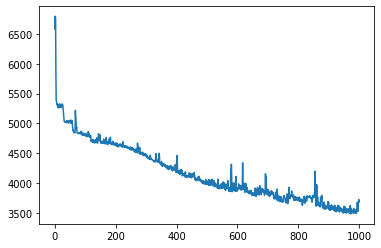

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)

### Save the model to be fetched later

In [39]:
# vrae.save('vrae_layer1_epoch1000.pth')
vrae.save('vrae_layer2_epoch1000.pth')

# To load a presaved model, execute:
# vrae.load('vrae_layer1_epoch1000.pth')
# vrae.load('vrae_layer2_epoch1000.pth')

In [19]:
vrae.is_fitted

True

### Transform the input timeseries to encoded latent vectors

In [20]:
z_run = vrae.transform(test_dataset)
z_run

array([[ 2.80142164e+00,  1.20445335e+00, -2.79346776e+00,
        -1.39484012e+00, -2.40996122e+00, -1.11354303e+00,
        -4.85031843e+00, -1.66283667e+00,  2.02514362e+00,
         2.06104660e+00,  3.26601577e+00,  1.53392470e+00,
         2.12194383e-01,  1.47253156e+00, -1.51883459e+00,
        -1.19762614e-01, -2.67670894e+00, -1.07450950e+00,
        -7.12125003e-01, -9.87213373e-01],
       [ 2.75077891e+00,  1.09669828e+00, -2.70525885e+00,
        -1.26531875e+00, -2.43550444e+00, -1.05714047e+00,
        -4.75787497e+00, -1.64172709e+00,  2.00207615e+00,
         1.98529148e+00,  3.26791358e+00,  1.65132582e+00,
         2.99677670e-01,  1.55921924e+00, -1.47358871e+00,
         2.93582022e-01, -2.64307475e+00, -1.07308042e+00,
        -8.28648329e-01, -6.94355905e-01],
       [ 2.82464504e+00,  1.21830404e+00, -2.98201966e+00,
        -1.57105207e+00, -2.58231735e+00, -1.29870462e+00,
        -5.16973352e+00, -1.64282632e+00,  2.21542382e+00,
         1.88968420e+00,  3.3

In [21]:
z_run.shape

(36, 20)

In [22]:
from einops import rearrange
import torch.nn as nn

In [23]:
def concat_recon(recon_output):
    
    w,b,f = recon_output.shape
    tmp = rearrange(recon_output, 'w b f -> b w f')
    output = tmp.reshape(w*b,f)

    return output

def inverse_minmax(x):
    
    inv_x = scaler.inverse_transform(x)
    
    return inv_x

def eval_recon(recon, real, undo = True):
    criterion = nn.MSELoss()
    
    if undo == True:
        # undo minmax scaling
        recon = inverse_minmax(recon)
    
    r = recon.shape[0]
    real = real[:r,:]
    
    # get shape
    print(recon.shape)
    print(real.shape)

    # compute loss
    loss = criterion(torch.tensor(recon), torch.tensor(real))
    
    return loss

def get_diff(recon, real, undo = True):
    if undo == True:
        # undo minmax scaling
        recon = inverse_minmax(recon)
    
    r = recon.shape[0]
    real = real[:r,:]
    
    return recon, real, np.abs(recon-real)

## Reconstruct

### Train

In [24]:
# train reconstruct
train_recon = vrae.reconstruct(train_dataset)
print(train_recon.shape)

(100, 223, 92)


In [25]:
train_recon = concat_recon(train_recon)
train_recon.shape

(22300, 92)

In [26]:
eval_recon(train_recon, TRAIN_DF)

(22300, 92)
(22300, 92)


tensor(3.5704e+13, dtype=torch.float64)

In [27]:
eval_recon(train_recon, TRAIN_SCALED, False)

(22300, 92)
(22300, 92)


tensor(0.3956, dtype=torch.float64)

### Test

In [28]:
# test reconstruct
test_recon = vrae.reconstruct(test_dataset)
print(test_recon.shape)

(100, 36, 92)


In [29]:
test_recon = concat_recon(test_recon)
test_recon.shape

(3600, 92)

In [30]:
eval_recon(test_recon, TEST_DF)

(3600, 92)
(3600, 92)


tensor(4.5463e+12, dtype=torch.float64)

In [31]:
eval_recon(test_recon, TEST_SCALED, False)

(3600, 92)
(3600, 92)


tensor(1.0238, dtype=torch.float64)

## Visualize

### Visualize Train Difference

In [32]:
train_recon, train_real, train_diff  = get_diff(train_recon, TRAIN_SCALED, False)
train_diff.shape

(22300, 92)

In [33]:
train_recon = pd.DataFrame(train_recon, columns= cols)
train_real = pd.DataFrame(train_real, columns= cols)
train_diff = pd.DataFrame(train_diff, columns= cols)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

plt.rcParams["figure.figsize"] = (20,5)

for i in cols:
    print(f'Saving plot {i}')
    plt.plot(train_diff[i])
    plt.title(f'{i}')
    plt.savefig(f'./plots/train/layer2/{i}.png')
    plt.clf() # Clear the current figure

# plt.plot(train_diff[cols[random.randrange(92)]])
# plt.title(f'{cols[random.randrange(92)]}')

Saving plot Device2Port1_AVG_INBPS
Saving plot Device2Port1_AVG_OUTBPS
Saving plot Device2Port4_AVG_INBPS
Saving plot Device2Port4_AVG_OUTBPS
Saving plot Device2Port6_AVG_INBPS
Saving plot Device2Port6_AVG_OUTBPS
Saving plot Device2Port8_AVG_INBPS
Saving plot Device2Port8_AVG_OUTBPS
Saving plot Device2Port10_AVG_INBPS
Saving plot Device2Port10_AVG_OUTBPS
Saving plot Device2Port12_AVG_INBPS
Saving plot Device2Port12_AVG_OUTBPS
Saving plot Device2Port14_AVG_INBPS
Saving plot Device2Port14_AVG_OUTBPS
Saving plot Device2Port19_AVG_INBPS
Saving plot Device2Port19_AVG_OUTBPS
Saving plot Device2Port21_AVG_INBPS
Saving plot Device2Port21_AVG_OUTBPS
Saving plot Device2Port22_AVG_INBPS
Saving plot Device2Port22_AVG_OUTBPS
Saving plot Device2Port23_AVG_INBPS
Saving plot Device2Port23_AVG_OUTBPS
Saving plot Device2Port24_AVG_INBPS
Saving plot Device2Port24_AVG_OUTBPS
Saving plot Device2Port4097_AVG_INBPS
Saving plot Device2Port4097_AVG_OUTBPS
Saving plot Device15Port1_AVG_INBPS
Saving plot Device1

<Figure size 1440x360 with 0 Axes>

### Visualize Test Difference

In [35]:
test_recon, test_real, test_diff  = get_diff(test_recon, TEST_SCALED, False)
test_diff.shape

(3600, 92)

In [36]:
test_recon = pd.DataFrame(test_recon, columns= cols)
test_real = pd.DataFrame(test_real, columns= cols)
test_diff = pd.DataFrame(test_diff, columns= cols)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

plt.rcParams["figure.figsize"] = (20,5)

for i in cols:
    print(f'Saving plot {i}')
    plt.plot(test_diff[i])
    plt.title(f'{i}')
    plt.savefig(f'./plots/test/layer2/{i}.png')
    plt.clf() # Clear the current figure


# plt.plot(train_diff[cols[random.randrange(92)]])
# plt.title(f'{cols[random.randrange(92)]}')

Saving plot Device2Port1_AVG_INBPS
Saving plot Device2Port1_AVG_OUTBPS
Saving plot Device2Port4_AVG_INBPS
Saving plot Device2Port4_AVG_OUTBPS
Saving plot Device2Port6_AVG_INBPS
Saving plot Device2Port6_AVG_OUTBPS
Saving plot Device2Port8_AVG_INBPS
Saving plot Device2Port8_AVG_OUTBPS
Saving plot Device2Port10_AVG_INBPS
Saving plot Device2Port10_AVG_OUTBPS
Saving plot Device2Port12_AVG_INBPS
Saving plot Device2Port12_AVG_OUTBPS
Saving plot Device2Port14_AVG_INBPS
Saving plot Device2Port14_AVG_OUTBPS
Saving plot Device2Port19_AVG_INBPS
Saving plot Device2Port19_AVG_OUTBPS
Saving plot Device2Port21_AVG_INBPS
Saving plot Device2Port21_AVG_OUTBPS
Saving plot Device2Port22_AVG_INBPS
Saving plot Device2Port22_AVG_OUTBPS
Saving plot Device2Port23_AVG_INBPS
Saving plot Device2Port23_AVG_OUTBPS
Saving plot Device2Port24_AVG_INBPS
Saving plot Device2Port24_AVG_OUTBPS
Saving plot Device2Port4097_AVG_INBPS
Saving plot Device2Port4097_AVG_OUTBPS
Saving plot Device15Port1_AVG_INBPS
Saving plot Device1

<Figure size 1440x360 with 0 Axes>